In [1]:
# Import necessary modules
from tvb.simulator.lab import *
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
import numpy as np
import matplotlib.pyplot as plt
import time as tm
import itertools

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Load Structural Connectivity Matrix
con = connectivity.Connectivity.from_file()
nregions = len(con.region_labels)
con.weights = con.weights - con.weights * np.eye(nregions)  # Remove self-connections
con.speed = np.array([3.0])  # Set conduction speed
con.configure()

2024-09-21 13:07:36,526 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [3]:
# Define simulation parameters
seizure_regions = [62, 40, 47, 69, 72]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV']
simulation_length = 30000  # 30 seconds
dt = 0.1  # Integration step size [ms]
amplitude_thresholds = [-0.5, 1.0]  # Two different amplitude thresholds for stimulation

In [4]:
# Adjust the threshold for the last channel
amplitude_thresholds_last_channel = [threshold + 1 for threshold in amplitude_thresholds]

# Define stimulation parameters
stim_durations = [500, 1000, 1500]  # Low, Medium, High durations in ms
stim_taus = [10, 20, 30]  # Low, Medium, High tau values
stim_weight = 0.3  # Fixed weight

In [5]:
# Function to run a single TVB simulation with real-time stimulation
def run_tvb_simulation_with_real_time_stimulation(stim_duration, stim_tau):
    # Set up the model
    mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
    mod.a_rs = np.ones((76)) * (1.7402)
    
    # Define Epileptogenic Network (EZ, PZ, NIZ)
    mod.x0 = np.ones((76)) * (-2.3)  # NIZ
    mod.x0[[40]] = np.ones((1)) * (-1.4)   # EZ: lAMYG
    mod.x0[[47, 62]] = np.ones((2)) * (-1.6)  # EZ: lHC, lPHC
    mod.x0[[69]] = np.ones((1)) * (-1.7)   # PZ: lTCI
    mod.x0[[72]] = np.ones((1)) * (-1.8)   # PZ: lTCV

    # Set up the Coupling
    coupl = coupling.Difference(a=np.array([0.00015]))

    # Set up the Integrator
    hiss = noise.Additive(nsig=np.array([0.00003]))
    heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

    # Set up the Monitor
    mon = monitors.Raw()

    # Set up the Simulator
    sim = simulator.Simulator(model=mod, connectivity=con, coupling=coupl,
                              integrator=heunint, monitors=[mon])
    sim.configure()

    # Run the simulation with real-time stimulation
    raw_time = []
    raw_data = []
    stimulation_times = {region_idx: [] for region_idx in seizure_regions}  # Track stimulation times for each region
    stimulation_applied = {region_idx: False for region_idx in seizure_regions}

    for step in range(int(simulation_length / dt)):
        # Run simulation for one step
        (time, data), = sim.run(simulation_length=dt)
        raw_time.append(time)
        raw_data.append(data)
        
        # Check amplitude and apply stimulation if threshold is crossed and time is greater than 1000 ms
        if time[0] > 1000:
            for region_idx in seizure_regions:
                if not stimulation_applied[region_idx]:  # Only apply stimulation once per channel
                    region_data = data[:, 0, region_idx, 0]  # Use only state 0 for amplitude check
                    if region_idx == seizure_regions[-1]:  # Last channel
                        thresholds = amplitude_thresholds_last_channel
                    else:
                        thresholds = amplitude_thresholds
                    if np.any((region_data < thresholds[0]) | (region_data > thresholds[1])):
                        eqn_t = equations.PulseTrain()
                        eqn_t.parameters['onset'] = time[0]
                        eqn_t.parameters['T'] = stim_duration
                        eqn_t.parameters['tau'] = stim_tau

                        stimulus = patterns.StimuliRegion(temporal=eqn_t, connectivity=con, weight=np.array([stim_weight]))
                        stimulus.configure_space()
                        stimulus.configure_time(np.arange(time[0], time[0] + stim_duration, dt))
                        sim.stimulus = stimulus
                        stimulation_times[region_idx].append(time[0])
                        stimulation_applied[region_idx] = True
                        print(f"Stimulation applied to region {region_idx} ({names[seizure_regions.index(region_idx)]}) at time {time[0]} ms")
                        break  # Apply stimulation only once per time step

        # Print progress every 10% of the simulation
        if step % int(simulation_length / dt / 10) == 0:
            print(f"Simulation progress: {step * dt / simulation_length * 100:.2f}%")

    raw_time = np.concatenate(raw_time)
    raw_data = np.concatenate(raw_data)
    return raw_time, raw_data, stimulation_times

In [6]:
# Function to plot time series data with a vertical line for each stimulation onset
def plot_time_series(raw_time, raw_data, stimulation_times, stim_duration, stim_tau):
    fig, axs = plt.subplots(len(seizure_regions), 1, figsize=(15, 5*len(seizure_regions)), sharex=True)
    fig.suptitle(f'Time Series for All Regions\nStim Duration: {stim_duration}ms, Tau: {stim_tau}')

    for idx, (region_idx, name) in enumerate(zip(seizure_regions, names)):
        axs[idx].plot(raw_time, raw_data[:, 0, region_idx, 0], label='State 0', alpha=0.7)
        axs[idx].plot(raw_time, raw_data[:, 1, region_idx, 0], label='State 1', alpha=0.7)
        axs[idx].plot(raw_time, raw_data[:, 2, region_idx, 0], label='State 2', alpha=0.7)
        
        if region_idx == seizure_regions[-1]:
            thresholds = amplitude_thresholds_last_channel
        else:
            thresholds = amplitude_thresholds
        axs[idx].axhline(y=thresholds[1], color='k', linestyle='--', label='Upper Threshold')
        axs[idx].axhline(y=thresholds[0], color='k', linestyle='--', label='Lower Threshold')
        
        for stim_time in stimulation_times[region_idx]:
            axs[idx].axvline(x=stim_time, color='r', linestyle='--', label='Stimulation')
        
        axs[idx].set_ylim(-5, 5)  # Set y-axis limits to show amplitude range
        axs[idx].set_xlim(0, simulation_length)  # Ensure x-axis goes till 30 seconds
        axs[idx].set_ylabel('Amplitude')
        axs[idx].set_title(f'Region: {name}')
        axs[idx].legend(loc='upper right')
    
    axs[-1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

Running simulation with parameters: Duration=500ms, Tau=10
Simulation progress: 0.00%
Simulation progress: 10.00%
Stimulation applied to region 47 (lHC) at time 3143.6000000000004 ms
Stimulation applied to region 40 (lAMYG) at time 3241.9 ms
Stimulation applied to region 62 (lPHC) at time 3515.5 ms
Simulation progress: 20.00%
Stimulation applied to region 69 (lTCI) at time 7741.3 ms
Simulation progress: 30.00%
Simulation progress: 40.00%
Stimulation applied to region 72 (lTCV) at time 13639.2 ms


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/simulator/history.py:204: RuntimeWarning: overflow encountered in cast
  self.buffer[step % self.n_time] = new_state[self.cvars]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _numba_dfun
  return self.ufunc(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: overflow encountered in _numba_dfun
  return self.ufunc(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/simulator/coupling.py:483: RuntimeWarning: invalid value encountered in subtract
  return x_j - x_i


Simulation progress: 50.00%
Simulation progress: 60.00%
Simulation progress: 70.00%
Simulation progress: 80.00%
Simulation progress: 90.00%


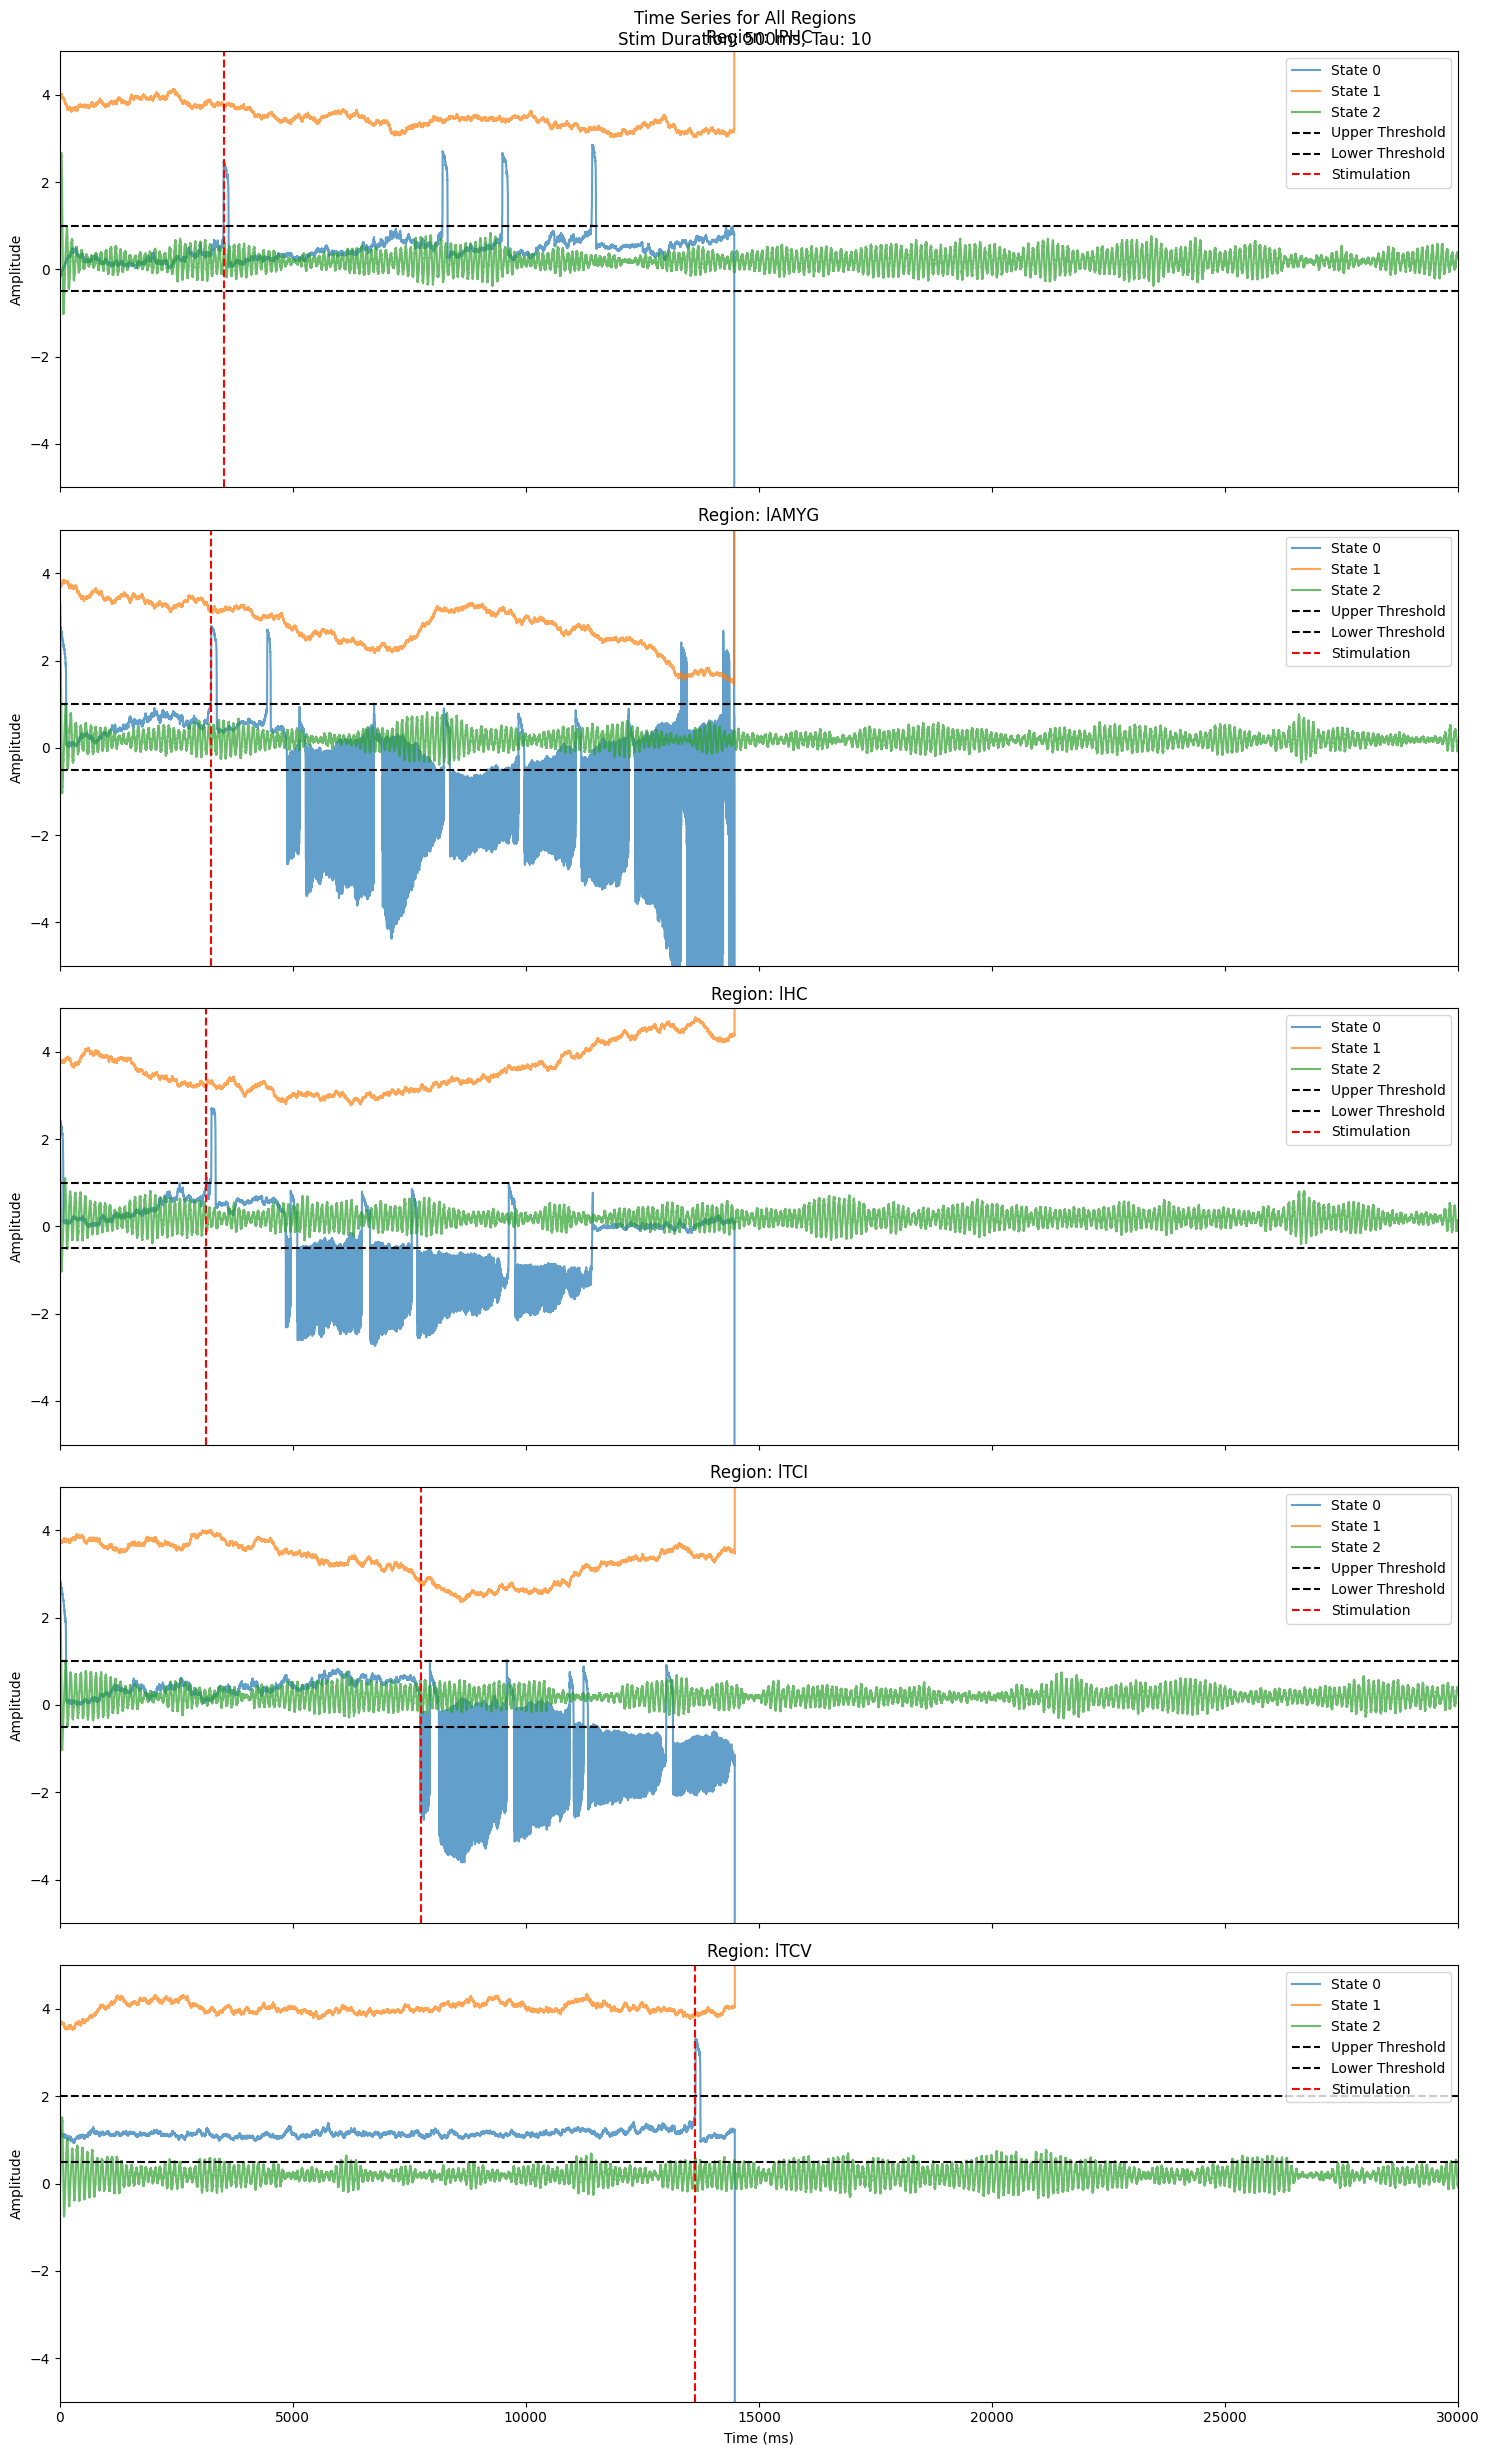

Running simulation with parameters: Duration=500ms, Tau=20
Simulation progress: 0.00%
Simulation progress: 10.00%
Stimulation applied to region 47 (lHC) at time 3143.6000000000004 ms
Stimulation applied to region 40 (lAMYG) at time 3241.9 ms
Stimulation applied to region 62 (lPHC) at time 3515.5 ms
Simulation progress: 20.00%
Stimulation applied to region 69 (lTCI) at time 7741.3 ms
Simulation progress: 30.00%
Simulation progress: 40.00%
Stimulation applied to region 72 (lTCV) at time 13639.2 ms
Simulation progress: 50.00%
Simulation progress: 60.00%
Simulation progress: 70.00%
Simulation progress: 80.00%
Simulation progress: 90.00%


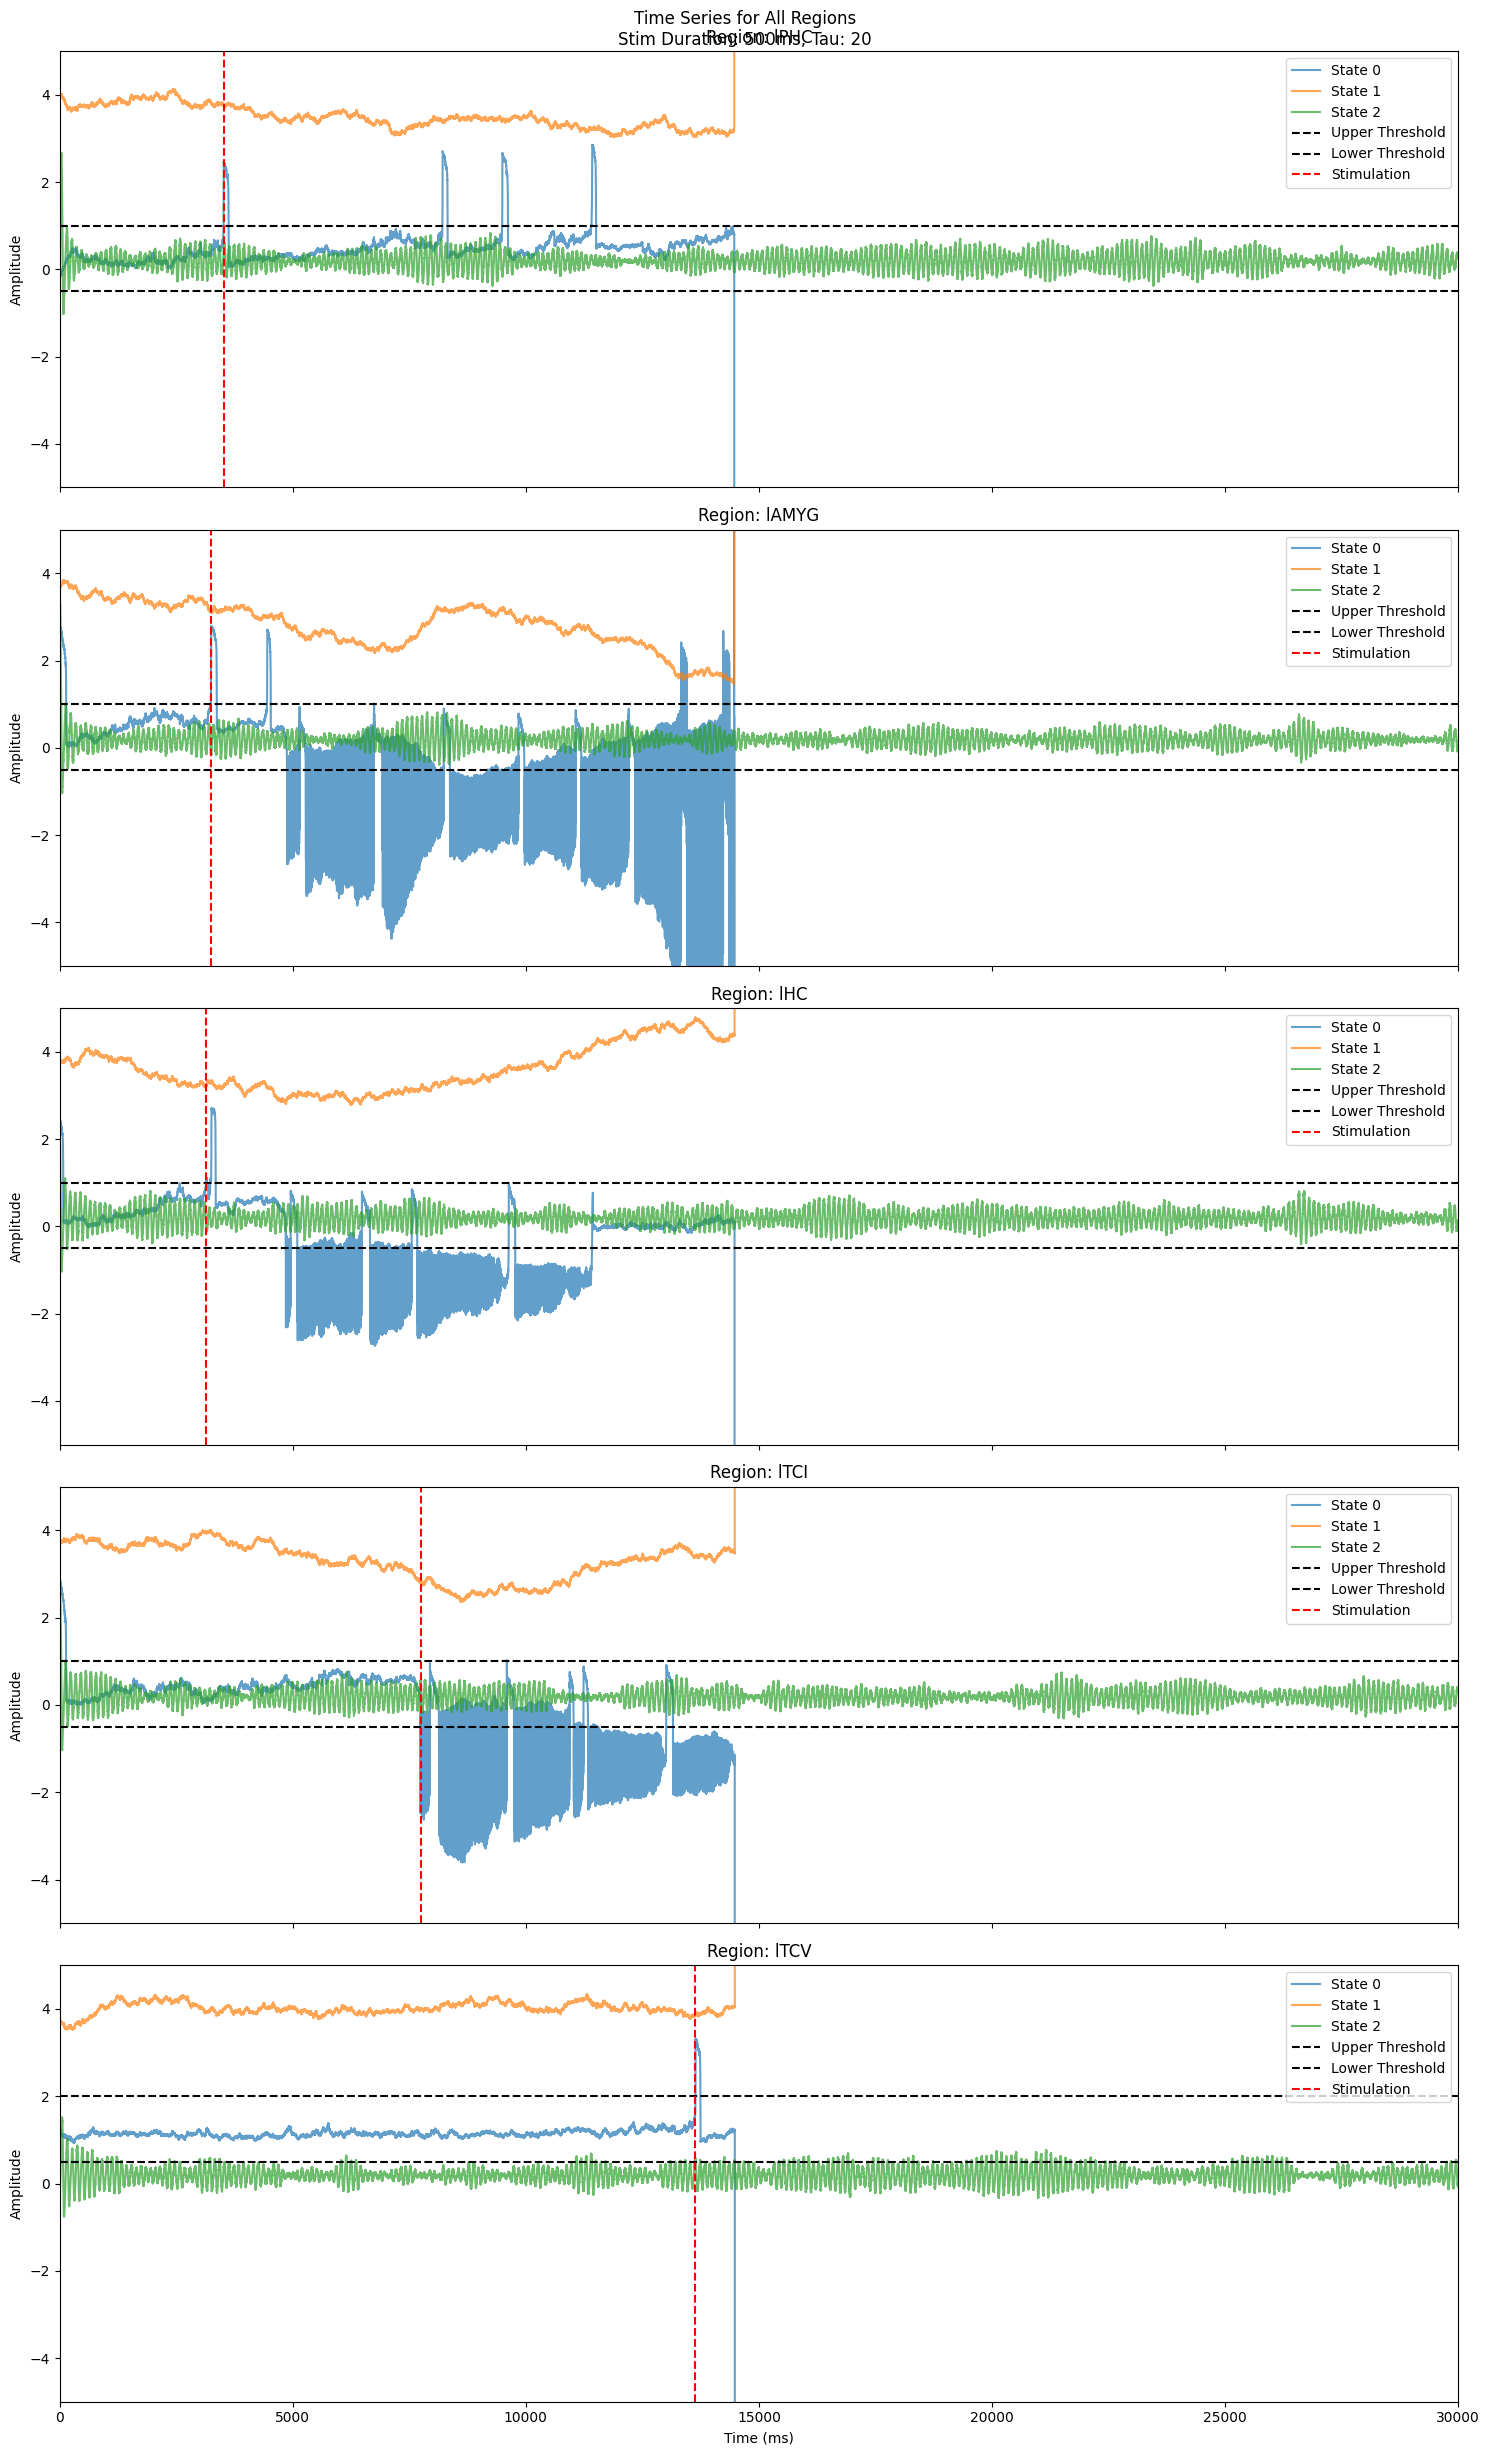

Running simulation with parameters: Duration=500ms, Tau=30
Simulation progress: 0.00%
Simulation progress: 10.00%
Stimulation applied to region 47 (lHC) at time 3143.6000000000004 ms
Stimulation applied to region 40 (lAMYG) at time 3241.9 ms
Stimulation applied to region 62 (lPHC) at time 3515.5 ms
Simulation progress: 20.00%
Stimulation applied to region 69 (lTCI) at time 7741.3 ms
Simulation progress: 30.00%
Simulation progress: 40.00%
Stimulation applied to region 72 (lTCV) at time 13639.2 ms
Simulation progress: 50.00%
Simulation progress: 60.00%
Simulation progress: 70.00%
Simulation progress: 80.00%


KeyboardInterrupt: 

In [8]:
# Main function to run the simulation and plot results
def main():
    stim_params_combinations = list(itertools.product(stim_durations, stim_taus))

    for stim_duration, stim_tau in stim_params_combinations:
        print(f"Running simulation with parameters: Duration={stim_duration}ms, Tau={stim_tau}")
        
        raw_time, raw_data, stimulation_times = run_tvb_simulation_with_real_time_stimulation(stim_duration, stim_tau)
        plot_time_series(raw_time, raw_data, stimulation_times, stim_duration, stim_tau)

    print("All simulations and plotting completed.")

# Run the main function
if __name__ == "__main__":
    main()